In [1]:
import torch
import numpy as np
import os.path as osp
import torch.nn.functional as F

from torch import nn
from torch import optim
from torch.utils.data import Dataset

from shapeglot.simple_utils import unpickle_data
from shapeglot.in_out.rnn_data_preprocessing import make_dataset_for_rnn_based_model
from shapeglot.in_out.shapeglot_dataset import ShapeglotDataset
from shapeglot.in_out.geometry import vgg_image_features, pc_ae_features
from shapeglot.models.neural_utils import MLPDecoder, smoothed_cross_entropy
from shapeglot.models.encoders import LanguageEncoder, PretrainedFeatures
from shapeglot.models.listener import Listener
from shapeglot.vis_utils import visualize_example
from shapeglot import vis_utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Define directories with data 
### [ assumes you have ran download_data.sh ]

In [2]:
top_data_dir = '../../data/main_data_for_chairs'
top_pretrained_feat_dir = '../../data/main_data_for_chairs/pretrained_features'
top_image_dir = osp.join(top_data_dir, 'images/shapenet/')
vis_utils.top_image_dir = top_image_dir

### Load data (Assumes you preprocessed the data, with notebooks/prepare_chair_in_context_data.ipynb)

In [3]:
# Load game-data
data_name = 'game_data.pkl'
game_data, word_to_int, int_to_word, int_to_sn_model, sn_model_to_int, sorted_sn_models =\
unpickle_data(osp.join(top_data_dir, data_name))

# Load pre-trained 2D/3D features.
vgg_feats_file = osp.join(top_pretrained_feat_dir, 'shapenet_chair_vgg_fc7_embedding.pkl')
vgg_feats = vgg_image_features(int_to_sn_model, 'chair', vgg_feats_file, python2_to_3=True)

pc_feats_file = osp.join(top_pretrained_feat_dir, 'shapenet_chair_pcae_128bneck_chamfer_embedding.npz')
pc_feats = pc_ae_features(int_to_sn_model, pc_feats_file)

### Prepare data for training (train/val splits, max-size, keep-only-correct etc.)

In [4]:
max_seq_len = 33              # Maximum size (in tokens) per utterance.
split_sizes = [0.8, 0.1, 0.1] # Train-val-test sizes.
random_seed = 2004
unique_test_geo = True        # If true, the test/train/val splits have 'targets' that are disjoint sets.
only_correct = True           # Drop all not correctly guessed instances.

net_data, split_ids, _, net_data_mask = \
make_dataset_for_rnn_based_model(game_data, 
                                 split_sizes, 
                                 max_seq_len,
                                 drop_too_long=True,
                                 only_correct=only_correct,
                                 unique_test_geo=unique_test_geo,
                                 replace_not_in_train=True,
                                 geo_condition=None, 
                                 bias_train=False, 
                                 seed=random_seed)


dataloaders = {}
num_workers = 8
batch_size = 2048 # Yes this is a big batch-size.

for split in ['train', 'val', 'test']:
    dataset = ShapeglotDataset(net_data[split])
    dataloaders[split] = torch.utils.data.DataLoader(dataset=dataset,
                                                     batch_size=batch_size,
                                                     shuffle=split=='train',
                                                     num_workers=num_workers)

unique geometries in train/test/val 3608 451 451


### Define Models

In [8]:
embedding_dim = 100  # Dimension of INPUT space of LSTM
n_hidden = 100       # LSTM hidden size
vocab_size = len(int_to_word)
train_epochs = 100
learning_rate = 0.005
reg_gamma = 0.005    # Weight regularization on FC layers

visual_encoder = PretrainedFeatures(torch.Tensor(vgg_feats), embed_size=embedding_dim)
pc_encoder = PretrainedFeatures(torch.Tensor(pc_feats), embed_size=embedding_dim)
lang_encoder = LanguageEncoder(n_hidden, embedding_dim, vocab_size)
mlp_decoder = MLPDecoder(n_hidden*2, [100, 50, 1], True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
listener = Listener(lang_encoder, visual_encoder, mlp_decoder, pc_encoder).to(device)
optimizer = optim.Adam(listener.parameters(), lr=learning_rate)

### Train the model (if you let it run for 150 epochs should reach ~78% accuracy)

In [9]:
best_val_accuracy = 0.0
best_test_accuracy = 0.0

for epoch in range(1, train_epochs+1):
    for phase in ['train', 'val', 'test']:
        if phase == 'train':            
            listener.train()
        else:
            listener.eval()

        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        for context_ids, targets, tokens in dataloaders[phase]:
            context_ids = context_ids.to(device)
            targets = targets.to(device)
            tokens = tokens.to(device)
    
            with torch.set_grad_enabled(phase == 'train'):
                logits = listener(context_ids, tokens)
                loss = smoothed_cross_entropy(logits, targets)                            
                reg_loss = 0.0
                
                for p in visual_encoder.named_parameters():
                    if 'fc.weight' == p[0]:
                        reg_loss += p[1].norm(2)
                
                for p in pc_encoder.named_parameters():
                    if 'fc.weight' == p[0]:
                        reg_loss += p[1].norm(2)
                        
                reg_loss *= reg_gamma                
                loss += reg_loss
                
                _, preds = torch.max(logits, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    listener.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            # statistics
            running_loss += loss.item() * targets.size(0)
            running_corrects += torch.sum(preds == targets)
        
        n_examples = len(dataloaders[phase].dataset)
        epoch_loss = running_loss / n_examples
        epoch_acc = running_corrects.double() / n_examples
        
        if phase == 'val':
            if epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                val_improved = True
            else:
                val_improved = False
        
        if phase == 'test' and val_improved:
            best_test_accuracy = epoch_acc
                        
        print('{} Epoch {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))
    print('Best test so far: {:.4f}'.format(best_test_accuracy))

1 Epoch train Loss: 1.1431 Acc: 0.3885
1 Epoch val Loss: 1.1139 Acc: 0.3899
1 Epoch test Loss: 1.1163 Acc: 0.4039
Best test so far: 0.4039
2 Epoch train Loss: 1.0708 Acc: 0.4920
2 Epoch val Loss: 1.0199 Acc: 0.5501
2 Epoch test Loss: 1.0176 Acc: 0.5522
Best test so far: 0.5522
3 Epoch train Loss: 1.0080 Acc: 0.5686
3 Epoch val Loss: 0.9749 Acc: 0.6013
3 Epoch test Loss: 0.9694 Acc: 0.6083
Best test so far: 0.6083
4 Epoch train Loss: 0.9664 Acc: 0.6108
4 Epoch val Loss: 0.9389 Acc: 0.6328
4 Epoch test Loss: 0.9209 Acc: 0.6575
Best test so far: 0.6575
5 Epoch train Loss: 0.9358 Acc: 0.6409
5 Epoch val Loss: 0.9121 Acc: 0.6440
5 Epoch test Loss: 0.9028 Acc: 0.6692
Best test so far: 0.6692
6 Epoch train Loss: 0.9127 Acc: 0.6555
6 Epoch val Loss: 0.8992 Acc: 0.6684
6 Epoch test Loss: 0.8857 Acc: 0.6849
Best test so far: 0.6849
7 Epoch train Loss: 0.8881 Acc: 0.6762
7 Epoch val Loss: 0.8775 Acc: 0.6867
7 Epoch test Loss: 0.8667 Acc: 0.6988
Best test so far: 0.6988
8 Epoch train Loss: 0.8745 

59 Epoch train Loss: 0.7139 Acc: 0.8107
59 Epoch val Loss: 0.7947 Acc: 0.7650
59 Epoch test Loss: 0.7717 Acc: 0.7764
Best test so far: 0.7725
60 Epoch train Loss: 0.7132 Acc: 0.8113
60 Epoch val Loss: 0.7848 Acc: 0.7731
60 Epoch test Loss: 0.7646 Acc: 0.7771
Best test so far: 0.7771
61 Epoch train Loss: 0.7125 Acc: 0.8112
61 Epoch val Loss: 0.7882 Acc: 0.7673
61 Epoch test Loss: 0.7605 Acc: 0.7790
Best test so far: 0.7771
62 Epoch train Loss: 0.7086 Acc: 0.8142
62 Epoch val Loss: 0.7902 Acc: 0.7609
62 Epoch test Loss: 0.7686 Acc: 0.7724
Best test so far: 0.7771
63 Epoch train Loss: 0.7105 Acc: 0.8141
63 Epoch val Loss: 0.7827 Acc: 0.7707
63 Epoch test Loss: 0.7637 Acc: 0.7771
Best test so far: 0.7771
64 Epoch train Loss: 0.7116 Acc: 0.8124
64 Epoch val Loss: 0.7899 Acc: 0.7683
64 Epoch test Loss: 0.7690 Acc: 0.7750
Best test so far: 0.7771
65 Epoch train Loss: 0.7077 Acc: 0.8165
65 Epoch val Loss: 0.7917 Acc: 0.7679
65 Epoch test Loss: 0.7736 Acc: 0.7687
Best test so far: 0.7771
66 Epo

KeyboardInterrupt: 

### Collect responses of a trained (!) listener (last epoch) and visualize what its predictions.

In [10]:
listener.eval()
guesses = []
scores = []
phase = 'test'
score = 0.0
for context_ids, targets, tokens in dataloaders[phase]:
    context_ids = context_ids.to(device)
    targets = targets.to(device)
    tokens = tokens.to(device)        
    with torch.set_grad_enabled(phase == 'train'):
        logits = listener(context_ids, tokens)
        scores.append(F.softmax(logits, dim=1).to('cpu').numpy())
        _, preds = torch.max(logits, 1)
        guesses.append(preds.to('cpu').numpy())
        score += torch.sum(preds == targets)
score = score.item() / float(len(dataloaders[phase].dataset))
guesses = np.hstack(guesses)
scores = np.vstack(scores)
test_data = dataloaders['test'].dataset

Predicted Probabilities: 0.00 0.19 0.80
Utterance: it is round , open at the lower back , and only three legs can be seen 
Guessed correct: True
Target: right-most


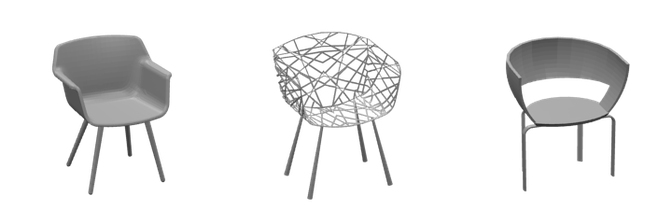

In [21]:
rid = np.random.randint(len(test_data))
chair_ids, target, utterance = test_data[rid]
guess = guesses[rid] == target
print ('Predicted Probabilities: {:.2f} {:.2f} {:.2f}'.format(*scores[rid]))
visualize_example(chair_ids, utterance, target, sorted_sn_models, int_to_word, guess=guess)